# Project 1 - Colorizing the Prokudin-Gorskii Photo Collection

Name: Filip Malm-Bägén

This notebook demonstrates the process of aligning images using an image pyramid and calculating NCC. The code assumes that the user has a folder called _data_ in the parent directory of the notebook with the .tif images. The notebook is structured as follows:

* Imports and dependencies


### Imports and Dependencies


In [1]:
import os
import cv2
import numpy as np
import skimage.io as skio
import matplotlib.pyplot as plt
from skimage import img_as_float, img_as_ubyte
from scipy.ndimage import convolve

## Function Definitions
### Shared Functions
These are the functions used in every alignment method.

In [2]:
def read_and_split_image(file_path):
    """This function reads an image and splits it into its RGB channels"""
    # read in the image
    im = skio.imread(file_path)

    # convert to double  
    im = img_as_float(im)

    # compute the height of each part (just 1/3 of total)
    height = np.floor(im.shape[0] / 3.0).astype(int)

    # separate color channels
    b = im[:height]
    g = im[height:2 * height]
    r = im[2 * height:3 * height]
    
    return r, g, b

def center(img: np.ndarray) -> np.ndarray:
    """This function takes an image and returns the center 1/2 of the image"""
    height, width = img.shape

    top = int(height / 4)
    bottom = int(3 * height / 4)
    left = int(width / 4)
    right = int(3 * width / 4)

    return img[top:bottom, left:right]

def normalized_cross_correlation(arr1: np.ndarray, arr2: np.ndarray) -> float:
    """This function computes the normalized cross-correlation between two arrays"""
    arr1_norm = (arr1 - np.mean(arr1)) / np.std(arr1)
    arr2_norm = (arr2 - np.mean(arr2)) / np.std(arr2)
    ncc = np.sum(arr1_norm * arr2_norm)

    return ncc

def align(im1: np.ndarray, im2: np.ndarray, max_shift: int = 32, initial_shift = (0, 0)):
    """This function takes two images and returns the second image shifted to align with the first image"""
    best_dx, best_dy = initial_shift
    max_ncc = -float('inf')

    for dx in range(-max_shift, max_shift + 1):
        for dy in range(-max_shift, max_shift + 1):
            # Shift im1 by (dx, dy)
            shifted_im1 = np.roll(im1, dx, axis=1)  # Shift in x
            shifted_im1 = np.roll(shifted_im1, dy, axis=0)  # Shift in y

            # Compute NCC on the centered image to avoid edge effects
            ncc = normalized_cross_correlation(center(im2), center(shifted_im1))

            # Update best shift
            if ncc > max_ncc:
                max_ncc = ncc
                best_dx, best_dy = dx, dy

    # Return the best shift
    return best_dx, best_dy

### Image adjustemnt functions
These functions are used for auto contrasting and auto white balance.

In [3]:
def auto_contrast(image):
    """This function takes an image and returns the auto-contrasted image"""
    # Compute the frequency of each pixel intensity value
    freq = np.zeros(256, dtype=int)
    for pixel in image.flatten():
        freq[int(pixel * 255)] += 1

    # Compute the prefix sum of the frequency array
    prefix = np.cumsum(freq)

    # Total number of pixels in the image
    total = prefix[-1]

    # Normalize the prefix sum
    normalized_prefix = prefix / total

    # Reassign each pixel intensity based on the normalized prefix sum
    new_image = np.interp(image.flatten(), np.linspace(0, 1, 256), normalized_prefix * 255).reshape(image.shape)

    return new_image / 255.0

def auto_white_balance(image, gray_point = 0.55):
    """This function takes an image and returns the automatic white balanced image"""
    # Compute the average color vector
    avg_color = np.mean(image, axis=(0, 1))

    # Perform white balancing
    balanced_image = image / avg_color * gray_point

    # Clip values to be in the valid range [0, 1]
    balanced_image = np.clip(balanced_image, 0, 1)

    return balanced_image

### Functions for .tif Colorization
These functions are unique to the .tif colorization process.

In [4]:
def align_with_pyramid(im1: np.ndarray, im2: np.ndarray):
    """This function takes two images and returns the second image shifted to align with the first image using a pyramid"""
    max_ncc = -float('inf')
    best_dx, best_dy = 0, 0

    # Start with the smallest images
    scaled1_blue = pyramid_scaledown(im2)
    scaled2_blue = pyramid_scaledown(scaled1_blue)
    scaled1_img1 = pyramid_scaledown(im1)
    scaled2_img1 = pyramid_scaledown(scaled1_img1)

    shift_dx, shift_dy = align(center(scaled2_img1), center(scaled2_blue))

    for dx in range(shift_dx * 3 - 3, shift_dx * 3 + 3 + 1):
        for dy in range(shift_dy * 3 - shift_dy, shift_dy * 3 + 3 + 1):
            # Shift im2 by (dx, dy)
            shifted_im1= np.roll(scaled1_img1, dx, axis = 1)  # Shift in x
            shifted_im1 = np.roll(shifted_im1, dy, axis = 0)  # Shift in y

            # Compute NCC on the centered image to avoid edge effects
            ncc = normalized_cross_correlation(center(shifted_im1), center(scaled1_blue))

            # Update best shift
            if ncc > max_ncc:
                max_ncc = ncc
                best_dx, best_dy = dx, dy

    max_ncc = float('-inf') 

    for dx in range(best_dx * 3 - 3, best_dx * 3 + 3 + 1):
        for dy in range(best_dy * 3 - 3, best_dy * 3 + 3 + 1):
            # Shift im2 by (dx, dy)
            shifted_im1 = np.roll(im1, dx, axis = 1)  # Shift in x
            shifted_im1 = np.roll(shifted_im1, dy, axis = 0)  # Shift in y

            # Compute NCC on the centered image to avoid edge effects
            ncc = normalized_cross_correlation(center(shifted_im1), center(im2))

            # Update best shift
            if ncc > max_ncc:
                max_ncc = ncc
                best_dx, best_dy = dx, dy
                best_align = shifted_im1

    return best_align, best_dx, best_dy

def pyramid_scaledown(img, kernelsize = 3, stride = 3):
    """This function scales down an image using a pyramid"""
    kernel = np.ones((kernelsize, kernelsize)) / (kernelsize * kernelsize) # average filter due to normalizing the kernel
    scaled_img = convolve(img, kernel, mode='reflect')
    scaled_img = scaled_img[::stride, ::stride]
    
    return scaled_img

### Functions for emir.tif Colorization
This function is unique for the coloriztion of the emir.tif image. It creates an edge mask which is used to align and colorize the image.

In [5]:
def sobel_filter(image):
    """This function applies the Sobel filter to an image"""
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize = 3)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize = 3)
    sobel_edges = np.hypot(sobel_x, sobel_y)
    
    return sobel_edges

## Photo Colorization
This section demonstrates the colorization of the Prokudin-Gorskii photo collection. They are divided into the jpg-section, which colorizes the images using the .jpg images, the tif-section, which colorizes the images using the .tif images, and the emir-section, which colorizes the emir.tif image.

### JPG Colorization

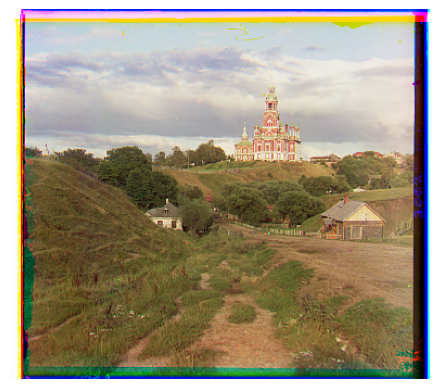

In [6]:
# imname = 'monastery.jpg'
imname = 'cathedral.jpg'
# imname = 'tobolsk.jpg'

r, g, b = read_and_split_image('../data/' + imname)

# Get the best shifts
dx_g, dy_g = align(g, b)
dx_r, dy_r = align(r, b)

# Apply the shifts
ag = np.roll(g, dx_g, axis=1)
ag = np.roll(ag, dy_g, axis=0)

ar = np.roll(r, dx_r, axis=1)
ar = np.roll(ar, dy_r, axis=0)

# Create a color image
im_out = np.dstack([ar, ag, b])

# Display the image
plt.imshow(im_out)
plt.axis('off')
plt.show()

### TIF Colorization
Align and colorize the images in the Prokudin-Gorskii collection.

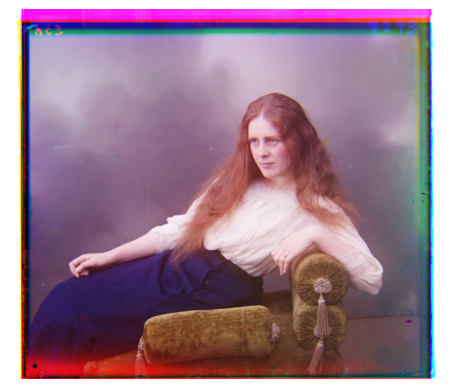

In [7]:
imname = 'lady.tif'

r, g, b = read_and_split_image('../data/' + imname)

# Align using the image pyramid
ar, dx_r, dy_r = align_with_pyramid(r, b)
ag, dx_g, dy_g = align_with_pyramid(g, b)

ar = np.roll(r, dx_r, axis = 1)
ar = np.roll(ar, dy_r, axis = 0)

ag = np.roll(g, dx_g, axis = 1)
ag = np.roll(ag, dy_g, axis = 0)

# Create a color image
im_out = np.dstack([ar, ag, b])

# Uncomment to apply auto contrast to the final aligned image
# im_out = auto_contrast(im_out)

# Uncomment to apply auto white balance to the final aligned image
# im_out = auto_white_balance(im_out)

# Display the image
plt.imshow(im_out)
plt.axis('off')
plt.show()

### Emir Colorization
Run this cell to colorize emir.tif. The code uses the Sobel filter to align the images and then colorizes the image.

Green channel alignment: dx = 21, dy = 49
Red channel alignment: dx = 36, dy = 108


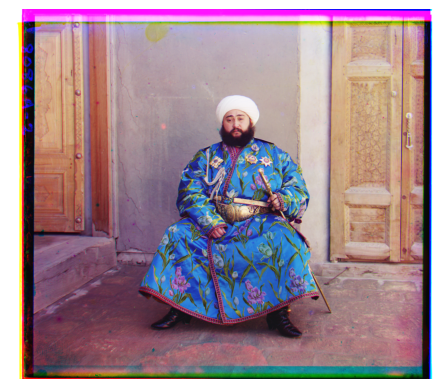

In [8]:
imname = 'emir.tif'

r, g, b = read_and_split_image('../data/' + imname)

# Apply Sobel filter to get edges
b_edges = sobel_filter(b)
g_edges = sobel_filter(g)
r_edges = sobel_filter(r)

# Align green and red channels to blue (using the Sobel edges)
ag_edges, dx_g, dy_g = align_with_pyramid(g_edges, b_edges)
ar_edges, dx_r, dy_r = align_with_pyramid(r_edges, b_edges)

# Print alignment results for each color channel
print(f"Green channel alignment: dx = {dx_g}, dy = {dy_g}")
print(f"Red channel alignment: dx = {dx_r}, dy = {dy_r}")

# Use the calculated shifts (dx_g, dy_g) and (dx_r, dy_r) from the Sobel-filtered images
ag = np.roll(g, dx_g, axis = 1)
ag = np.roll(ag, dy_g, axis = 0)

ar = np.roll(r, dx_r, axis = 1)
ar = np.roll(ar, dy_r, axis = 0)

# Stack the aligned channels to form the final color image
im_out = np.dstack([ar, ag, b])

# Display the final aligned image
plt.imshow(im_out)
plt.axis('off')
plt.show()

### Batch processing
Run this cell to colorize and return the _x_ and _y_ shift of every .tif file in folder_path.

In [ ]:
def process_image_file(file_path: str, show_image: bool = True, save_image: bool = False):
    """This function processes an image file"""
    r, g, b = read_and_split_image(file_path)

    # Automatic check for emir
    if os.path.basename(file_path) == 'emir.tif':
        # Apply Sobel filter to get edges
        b_edges = sobel_filter(b)
        g_edges = sobel_filter(g)
        r_edges = sobel_filter(r)

        # Align green and red channels to blue (using the Sobel edges)
        _, dx_g, dy_g = align_with_pyramid(g_edges, b_edges)
        _, dx_r, dy_r = align_with_pyramid(r_edges, b_edges)

    else:
        # Align using the image pyramid
        ar, dx_r, dy_r = align_with_pyramid(r, b)
        ag, dx_g, dy_g = align_with_pyramid(g, b)

    ar = np.roll(r, dx_r, axis = 1)
    ar = np.roll(ar, dy_r, axis = 0)

    ag = np.roll(g, dx_g, axis = 1)
    ag = np.roll(ag, dy_g, axis = 0)

    # Combine the aligned channels
    aligned_image = np.stack([ar, ag, b], axis = -1)

    # Display the aligned image
    if show_image:
        plt.imshow(aligned_image)
        plt.title(f"Aligned Image: {file_path}")
        plt.axis('off')
        plt.show()

    if save_image:
        folder_path = '../data/resulttt/'  # Change this to your folder path to save

        # Create the folder if it does not exist
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        filename = os.path.basename(file_path).replace('.tif', '.jpg')
        aligned_image_uint8 = img_as_ubyte(aligned_image)  # Convert to uint8
        skio.imsave(os.path.join(folder_path, filename), aligned_image_uint8)

    print(f"File: {file_path}")
    print(f"Red channel alignment: dx = {dx_r}, dy = {dy_r}")
    print(f"Green channel alignment: dx = {dx_g}, dy = {dy_g}")


# Process all .tif images in the folder
folder_path = '../data/'  # Change this to the folder path of the .tif images
for filename in os.listdir(folder_path):
    if filename.endswith('.tif'):
        file_path = os.path.join(folder_path, filename)
        process_image_file(file_path)